# 3.3 미래에 볼 영화의 평점 예측하기

데이터 분석을 통해 아직 사람들이 보지 않았지만 좋아할 만한 영화들을 추천할 수 있을까요? 넷플릭스같은 서비스들은 이러한 것들을 평점 예측 기본으로 제공하고 있습니다. 이번 절에서는 이러한 평점 예측 기법을 알아보겠습니다.

## Step 1 탐색: MovieLens 데이터 살펴보기
MovieLens 데이터는 총 3개의 데이터셋으로 분리되어 있으며 데이터셋을 구성하는 피처는 아래와 같습니다.

- 데이터셋 : 피처
- rating 데이터 : user_id(유저 번호), movie_id(영화 번호), rating(점수), time(데이터 등록시간)
- movie 데이터 : movie_id(영화 번호), title(영화 제목), genre(장르)
- user  데이터 : uesr_id(유저 번호), gender(성별), age(나이), occupation(직업-개인정보1), zipcode(주소 코드-개인정보2)

각 데이터는 '::' 구분자로 열을 구분하였기 때문에 read_csv() 함수를 사용할 때 delimiter='::' 파라미터를 포함해야 합니다. 3개의 데이터(rating_data, movie_data, user_data)를 각각 head() 함수로 살펴본 결과는 다음과 같습니다.

#### MovieLens 데이터셋의 기본 정보 구하기

In [1]:
# -*- coding: uft-8 -*-
%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data source : https://grouplens.org/datasets/movielens

rating_file_path = "data/ml-1m/ratings.dat"
movie_file_path = "data/ml-1m/movies.dat"
user_file_path = "data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path,
                                    names=['user_id', 'movie_id', 'rating', 'time'],
                                    delimiter='::', encoding= 'ISO-8859-1')
movie_data = pd.io.parsers.read_csv(movie_file_path,
                                   names=['movie_id', 'title', 'genre'],
                                   delimiter='::', encoding= 'ISO-8859-1')
user_data = pd.io.parsers.read_csv(user_file_path,
                                  names=['user_id', 'gender', 'age', 'occupation', 'zipcode'],
                                  delimiter='::', encoding= 'ISO-8859-1')

/home/ubuntu/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [2]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Step 2 분석: 탐색적 데이터 분석하기
탐색적 데이터 분석을 통해 영화 데이터를 살펴보자. 다음의 실행 결과는 영화의 개수와 연도별 탐색에 대한 출력 결과이다. 영화의 개수는 약 4,000여 개 정도라는 것을 알 수 있고, 1990년대 후반부터 2000년대 초반의 영화가 가장 많은 것을 알 수 있다. 영화의 연도 정보는 movie_data['title'].apply(lambda x:x[-5:-1]) 코드를 통해 추출한 것으로 영화의 제목 뒤에 따라붙는 연도 정보를 이용한 것이다.

#### 분석할 영화의 정보  탐색하기

In [5]:
# 총 영화의 개수를 출력합니다.
print("total number of movie in data:",len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 top10 연도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x:x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data: 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

In [6]:
# 연대별 영화의 개수를 출력합니다.
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


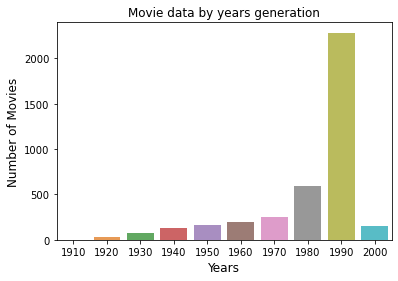

In [7]:
sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

다음으로 영화 데이터에서 가장 많이 등장한 장르가 무엇인지를 탐색해봅시다. movie_data의 피처인 genre는 '드라마 | 코미디 | 액션'처럼'|'이라는 구분자를 포함하여 여러 장르를 하나의 문자열에 포함하고 있습니다. 따라서 데이터에 등장하는 모든 개별 장르를 세기 위해서는 split() 함수로 genre 데이터를 분리해야 합니다. 각 장르마다의 등장 개수는 dictionary 자료로 저장합니다. 실행 코드는 다음과 같습니다.

#### 장르의 속성 탐색하기

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


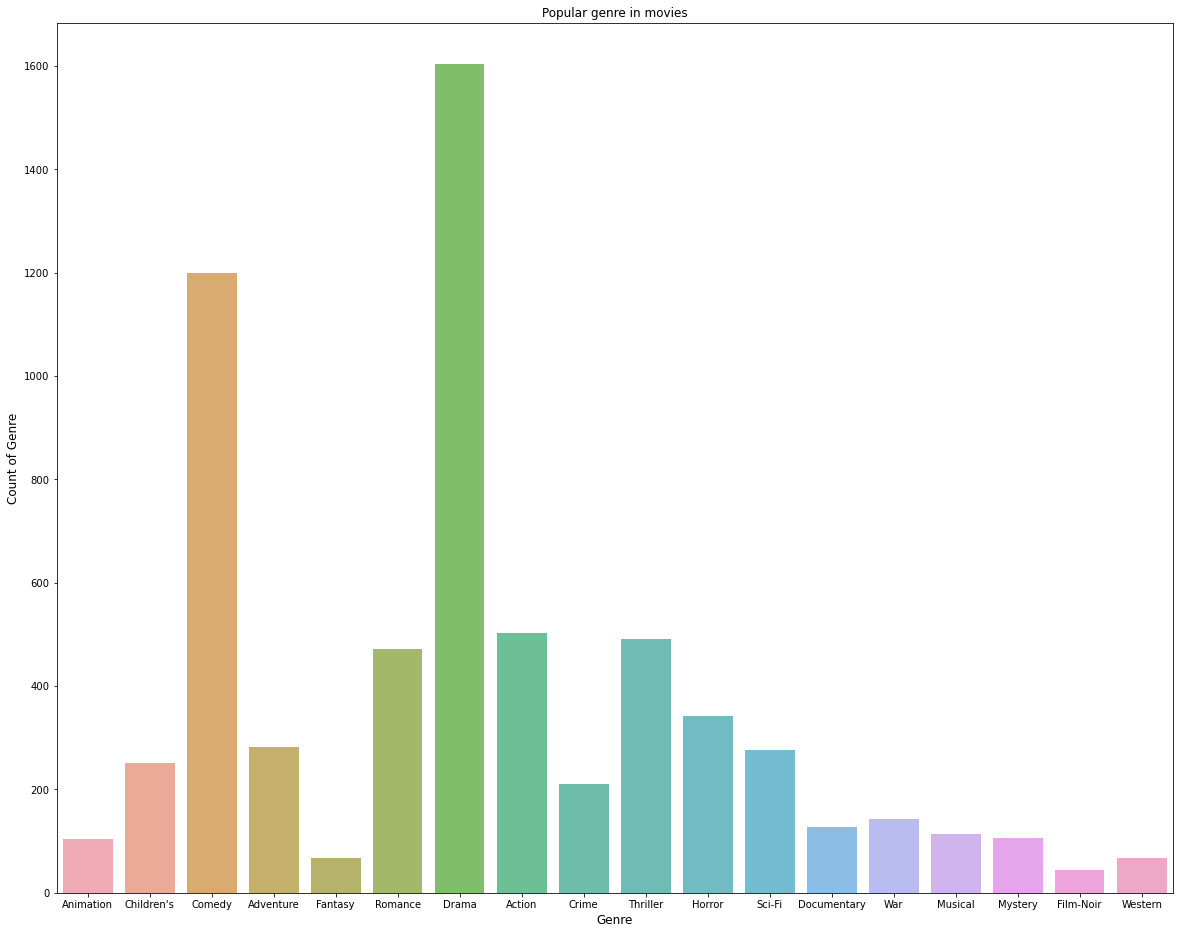

In [8]:
# 가장 많이 등장한 장르의 속성을 추출합니다. (예시: Drama)
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    
    # genre 피처를 '|' 구분자로 분리합니다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장합니다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [20,16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

그리고 분석 대상이 되는 유저의 수를 탐색해보면 총 6,040명으로 나타납니다.

#### 분석할 유저의 정보 탐색하기

In [9]:
# 유저의 수를 탐색합니다.
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


- 유저 데이터에 대한 탐색적 데이터 분석을 실행해 봅시다.
    - 유저의 성별 탐색 
    - 유저의 연령대 탐색

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


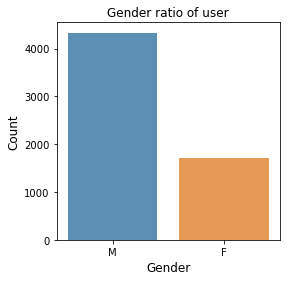

In [10]:
# 유저의 성별을 탐색합니다.
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [11]:
# 유저의 연령대를 탐색합니다.
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [12]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


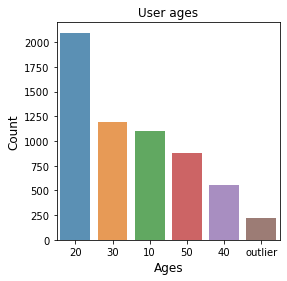

In [13]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

지금까지 user_data, movie_data 데이터의 특징을 살펴본 것은'평점 예측'의 측면에서는 중요한 탐색이라고 볼 수 없었습니다. 하지만 rating 데이터는 평점 예측 데이터 분석에 중요한 데이터이기때문에 조금 더 자세히 탐색을 수행할 필요가 있습니다.<br>
아래의 코드는 각 영화가 얼마나 많은 평가를 받았는지를 탐색합니다. 실행 결과 그래프는'movie_id'를 기준으로 groupby() 한뒤,'rating'에 count() 함수를 적용한 결과입니다. x축은 각 영화가 평가받은 횟수, y축은 각 영화가 평가받은 횟수를 의미합니다. 이를 통해 약 3,800여 개의 영화중 100개 미만의 평가를 받은 영화가 1,700여 개나 된다는 것을 알 수 있습니다. 이러한 영화들을 대상으로 한 '예상 평점'분석은 관람객에게 큰 의미가 있을 것입니다.

#### 평점 데이터의 정보 탐색하기

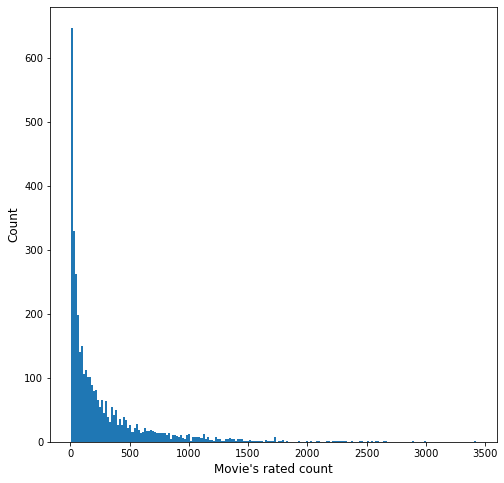

total number of movie in data : 3883
total number of movie rated below 100 : 1687


In [14]:
# 각 영화가 평가받은 횟수를 탐색합니다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8,8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

다음은 각 영화의 평균 평점을 알아보겠습니다. 아래의 코드에서는 agg() 함수로 각 영화당 rating의 개수와 평균값을 계산합니다. 평균값에 대한 시각화는 실행 결과와 같습니다. 대부분의 평점은 2점 ~ 4점 사이로 나타났으며, 이를 통해 대부분의 영화 평점은 2점 ~ 4점 사이의 값으로 예측될 것이라는 가설을 수립할 수 있습니다.

In [15]:
# 영화별 평균 평점을 탐색합니다.
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [16]:
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<AxesSubplot:>

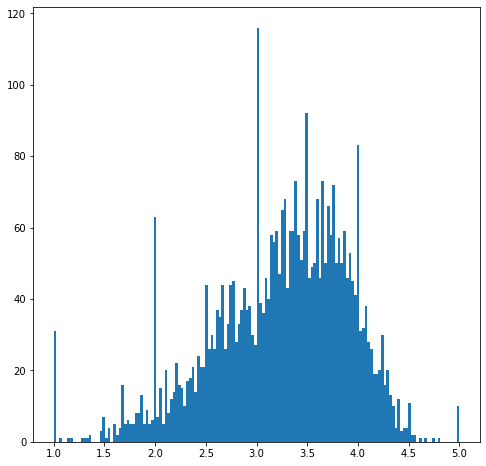

In [17]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

In [18]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력합니다.
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)



- 동일한 방식으로, 유저 그룹 단위의 평점 속성을 분석.
    - 유저별로 평가한 영화 개수
    - 유저별로 평가한 평균 영화 점수
    - 유저별로 평가한 영화 점수의 편차

In [19]:
# 유저별 영화 평가를 탐색합니다.
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(['count','mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']

In [20]:
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


<AxesSubplot:>

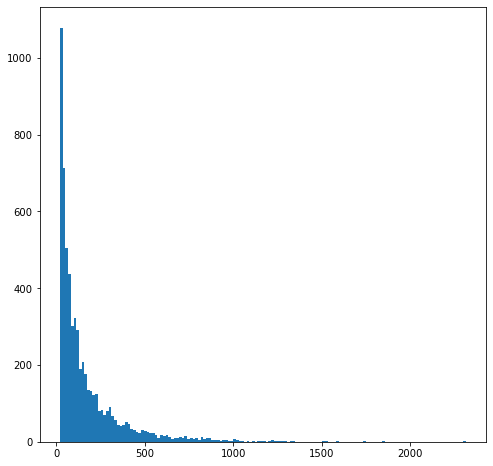

In [21]:
# 유저별로 평가한 영화 개수의 분포를 출력합니다.
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

<AxesSubplot:>

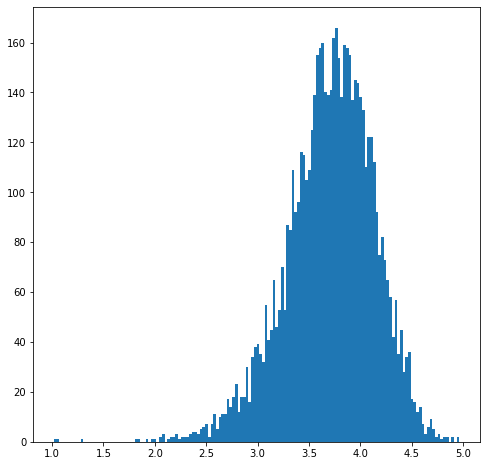

In [22]:
# 유저별로 평가한 영화 점수 평균의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

<AxesSubplot:>

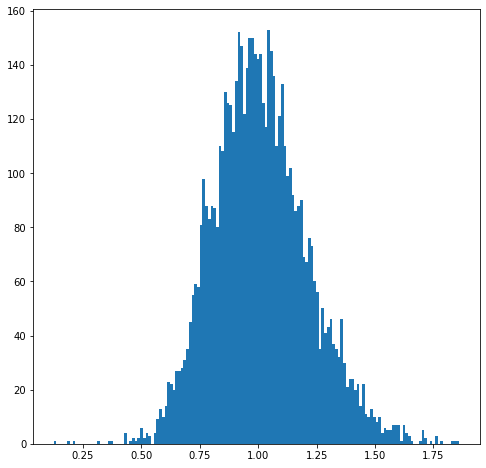

In [23]:
# 유저별로 평가한 영화 점수 편차의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

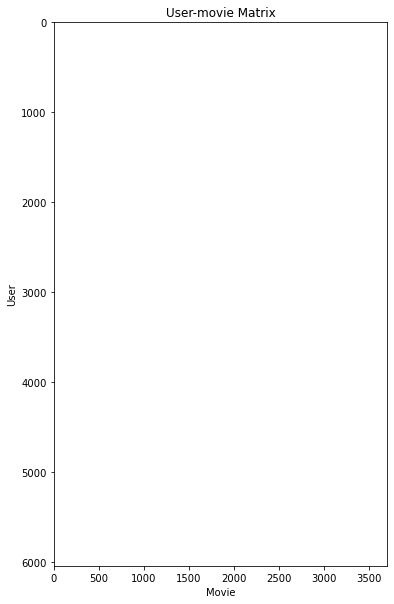

In [24]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성한다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(['user_id','movie_id']).unstack()

# user- movie 표를 시각화 한다
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

그런데 위의 그래프는 대부분의 공간에 색이 없는 행렬(희소 행렬)이라는 것을 알 수 있습니다. 이는 대부분의 Rating 점수가 아직 채워지지 않았다는 것을 의미합니다. 비어있는 Rating을 채워 넣을 수 있는 가장 대표적인 방법은 행렬의 빈 공간을 채우는 행렬완성기법입니다.

## Step 3 예측: 수학적 기봅을 활용해 평점 예측하기
행렬 완성은 행렬 분해방법을 이용합니다. 행렬 분해는 수학적 성질을 이용하여 하나의 행렬을 여러 개의 행렬 곱으로 나타내는 방법입니다. 본 예제에서는 행렬 분해 중에서도 가장 활용도가 높은 특이값 분해라는 방법을 활용하여 영화 평점을 예측할 것입니다. SVD란 mxn의 행렬 A를 아래의 그림과 같은 3개의 행렬 U,S,V로 나누는 것을 의미합니다. 그리고 이를 반대로 이용하면 3개의 행렬로 원래의 행렬 A를 근사할 수 있습니다.

라이브러리 사용법은 아래의 코드와 같습니다. 먼저 평점의 범위가 1 ~ 5인 Reader 객체를 생성합니다. 그리고 load_from_df() 함수와 build_full_trainset() 함수를 이용하여 rating 데이터를 surprise 라이브러리의 데이터셋 형태로 변환해줍니다. 마지막으로 SVD라는 클래스를 선언한 뒤, model.fit(train_data)로 행렬 완성 모델을 학습합니다. 일반적인 성능의 컴퓨터에서는 약 1분에서 5분 사이의 시간이 소요될 수 있습니다.

#### MovieLens 데이터에서 SVD 적용하기

In [26]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
           lr_all=0.005,
           reg_all=0.02,
           n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time fo model: %.2f seconds" % (train_end - train_start))

training time fo model: 79.48 seconds


다음으로 학습한 모델의 평점 예측 결과를 살펴보기 위해 한 명의 데이터를 선정합니다. 예제에서는 user_id가 4인 유저를 선정하였습니다.

#### 영화의 점수를 예측할 타겟 유저 선정하기

In [27]:
# user_id가 4인 유저의 영화 평가 데이터입니다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


4번 유저가 평가한 영화의 목록을 추출하는 과정은 다음과 같습니다. 아래 출력 결과는 유저의 영화관람 히스토리를 {movie_id : rating} 형태로 추출한 것입니다.

In [28]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출합니다.
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
    
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


이제 예측 모델에 4번 유저의 정보를 입력하여'아직 보지 않은 영화들의 평점'을 예측해봅시다. 이를 위해 model.test() 함수를 사용합니다. 이 함수의 입력 데이터인 test_data는 (target_user_id, movie_id, rating) 형태의 리스트여야 합니다. 다음 코드에서는 4번 유저가 아직 보지 않은 영화의 리스트로 test_data를 구성하였습니다. model.test(test_data)를 실행하면 4번 유저가 아직 보지 않은 영화들의 예측 평점을 반환합니다.

#### 타겟 유저가 보지 않은 영화중, 예상 평점이 높은 10개 선정

In [30]:
# 타겟 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))
    
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions,
                                                           user_id=target_user_id,
                                                           user_history=target_user_movie_rating_dict)
# tartet_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(),
                                    key=operator.itemgetter(1), reverse=True)[:10]
target_user_top10_predicted

[(213, 5),
 (326, 5),
 (527, 5),
 (602, 5),
 (858, 5),
 (904, 5),
 (912, 5),
 (923, 5),
 (1189, 5),
 (1193, 5)]

위의 실행 결과는 target_user_predictions에서 평점순으로 Top 10 영화의 id를 출력한 것입니다.

그리고 다음의 실행 결과는 Top 10 영화의 제목을 매칭하여 출력한 것입니다.

In [33]:
# 타이틀 정보를 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장합니다.
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title
    
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력합니다.
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Burnt By the Sun (Utomlyonnye solntsem) (1994) : 5
To Live (Huozhe) (1994) : 5
Schindler's List (1993) : 5
Great Day in Harlem, A (1994) : 5
Godfather, The (1972) : 5
Rear Window (1954) : 5
Casablanca (1942) : 5
Citizen Kane (1941) : 5
Thin Blue Line, The (1988) : 5
One Flew Over the Cuckoo's Nest (1975) : 5


## Step 4 평가: 예측 모델 평가하기
이제 우리가 스스로 의문을 가져야 할 때입니다. '과연 이 예측이 얼마나 정확한 예측일까?'라는 의문입니다. 이를 해소하기 위해서는 모델이 얼마나 정확하게 행렬을 완성했는지 평가해야 합니다. 행렬 완성의 가장 보편적인 평가 방법은 RMSE를 계산하는 것입니다.<br>
SVD 모델에서 RMSE를 출력하는 코드는 다음과 같습니다. 데이터를 학습 데이터셋과 테스트 데이터셋으로 분리한 뒤, 학습 데이터셋을 사용하여 SVD 모델을 학습합니다. 그리고 테스트 데이터로 predictions라는 예측값을 생성하여 RMSE를 계산합니다.

#### 예측 모델의 평가 방법

In [36]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
           lr_all=0.005,
           reg_all=0.02,
           n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 80.78 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8584


0.8584370162700776

- SVD 예제에서 하이퍼 파라미터를 바꿔가며 RMSE를 출력해 봅시다.
    - RMSE를 이용해 적당한 하이퍼 파라미터 n_factors를 찾기.
    - 하이버 파라미너 n_factors 설정 변화에 따른 RMSE 그래프를 출력해 보기.

#### 하이퍼 파라미터 튜닝 예시

In [39]:
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in range(1, 15):
    train_start = time.time()
    model = SVD(n_factors=n,
               lr_all=0.005,
               reg_all=0.02,
               n_epochs=100)
    model.fit(train_data)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------")
print("searching n_factors is finish.")

training time of model: 68.78 seconds
RMSE of test dataset in SVD model, n_factors=1
RMSE: 0.8817
------------------------------
training time of model: 69.89 seconds
RMSE of test dataset in SVD model, n_factors=2
RMSE: 0.8720
------------------------------
training time of model: 71.63 seconds
RMSE of test dataset in SVD model, n_factors=3
RMSE: 0.8656
------------------------------
training time of model: 73.57 seconds
RMSE of test dataset in SVD model, n_factors=4
RMSE: 0.8612
------------------------------
training time of model: 75.84 seconds
RMSE of test dataset in SVD model, n_factors=5
RMSE: 0.8594
------------------------------
training time of model: 77.69 seconds
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.8583
------------------------------
training time of model: 79.13 seconds
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.8570
------------------------------
training time of model: 81.74 seconds
RMSE of test dataset in SVD model, n_factors=8
RMSE: 0.8589

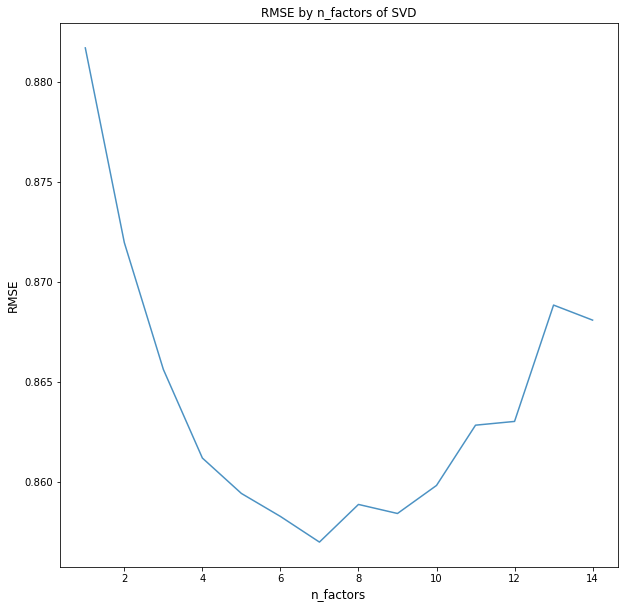

In [40]:
plt.plot(range(1,15), rmse_list_by_factors, alpha=0.8)
plt.title("RMSE by n_factors of SVD")
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

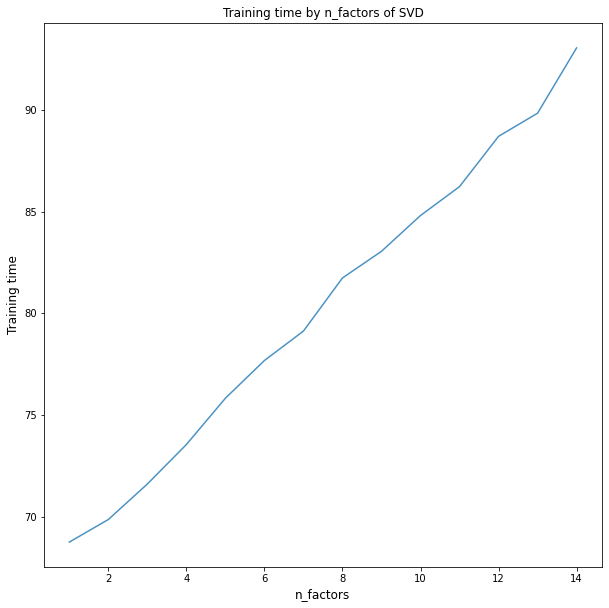

In [41]:
plt.plot(range(1, 15), ttime_list_by_factors, alpha=0.8)
plt.title('Training time by n_factors of SVD')
plt.ylabel('Training time', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

이번에는 4번 유저의 예측 평점과 실제 평점을 비교하는 시각화 그래프를 출력해봅시다. 아래의 코드는 4번 유저가 영화를 아직 보지 않았다는 가정하에 실제로 보았던 21개 영화의 가상 예측 평점을 계산한 것입니다.

#### 실제 평점과의 비교 시각화하기: 펑점 예측 단계

In [49]:
# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

In [50]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [51]:
target_user_movie_predict_dict

{260: 4.2314046153984055,
 480: 3.4081291373793627,
 1036: 3.8941590061157147,
 1097: 4.44209434917251,
 1196: 3.9339779462293922,
 1198: 4.339003080174997,
 1201: 4.6009261555725365,
 1210: 3.5017208924646215,
 1214: 4.37408917911147,
 1240: 4.184256426125829,
 1387: 4.428993238026559,
 1954: 4.380263933122104,
 2028: 4.653448223075578,
 2366: 4.253980527587912,
 2692: 4.194715073075323,
 2947: 4.2670407679104345,
 2951: 4.5030654694203545,
 3418: 4.3434331630038185,
 3468: 4.915279116673468,
 3527: 3.2600993246507057,
 3702: 3.92548638050681}

4번 유저가 실제로 관람했던 21개 영화에 대한 가상 예측 평점, 실제 평점, 그리고 영화의 제목을 하나로 출력한 결과는 다음과 같습니다.

#### 실제 평점과의 비교 시각화 하기

In [52]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.23
movie 2 : Jurassic Park (1993) - 4 / 3.41
movie 3 : Die Hard (1988) - 4 / 3.89
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.44
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.93
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.34
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.6
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.5
movie 9 : Alien (1979) - 4 / 4.37
movie 10 : Terminator, The (1984) - 5 / 4.18
movie 11 : Jaws (1975) - 5 / 4.43
movie 12 : Rocky (1976) - 5 / 4.38
movie 13 : Saving Private Ryan (1998) - 5 / 4.65
movie 14 : King Kong (1933) - 4 / 4.25
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.19
movie 16 : Goldfinger (1964) - 5 / 4.27
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.5
movie 18 : Thelma & Louise (1991) - 4 / 4.34
movie 19 : Hustler, The (1961) - 5 / 4.92
movie 20 : Predator (1987) - 1 / 3.26
movie 21 : Mad Max (1979) - 4 / 3.93


아래의 그래프는 지금까지의 분석 결과를 시각화한 것입니다. 약 1 ~ 2개의 정도의 영화를 제외하면 실제 평점과 가상 예측 평점이 크게 다르지 않은 것을 알 수 있습니다.

#### 실제 평점과의 비교 시각화하기

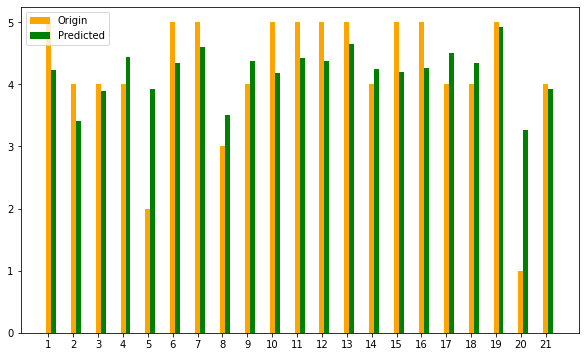

In [53]:
# 실제 점수와 예측 점수를 리스트로 추출합니다.
origin = origin_rating_list
predicted = predicted_rating_list
 
# 영화의 개수만큼 bar 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()

출처 : "이것이 데이터 분석이다 with 파이썬"